# Основы PyTorch

## Задача №1

- Объявите вещественные тензор `x` размера (3, 4, 5) и тензор `y` размера (2, 6, 5), иницилизируйте их равномерным распределением. 
- Создайте их копии на GPU, выведите их сумму и разность
- Затем измените форму тензора `y`, чтобы она совпадала с формой тензора `x`, получите тензор `z`  
- Переместите `z` на CPU

In [78]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt

In [79]:
x = torch.FloatTensor(3, 4, 5).uniform_()
y = torch.FloatTensor(2, 6, 5).uniform_()

In [80]:
x_cuda = x.cuda()
y_cuda = y.cuda()

In [81]:
print("Сумма = ", x_cuda.add(y_cuda.view(x_cuda.shape)))
print("Разность = ", x_cuda.sub(y_cuda.view(x_cuda.shape)))

Сумма =  tensor([[[0.1446, 0.7273, 1.3597, 0.9853, 1.1541],
         [0.6849, 0.6192, 0.5407, 1.5174, 0.2002],
         [1.2042, 0.7945, 1.5785, 1.4462, 1.4809],
         [0.5277, 1.0222, 0.1558, 1.2167, 0.8263]],

        [[1.6074, 0.3516, 1.1278, 0.9097, 0.9351],
         [1.4467, 0.9824, 0.5409, 0.7040, 1.4562],
         [1.8449, 1.1043, 1.5030, 1.7668, 0.9304],
         [0.5258, 1.5013, 0.6970, 1.2927, 0.8666]],

        [[0.7668, 1.0349, 1.3227, 0.9180, 0.3352],
         [0.0605, 1.0058, 1.0027, 1.3181, 1.2374],
         [0.1137, 1.4355, 0.5255, 0.2394, 0.7812],
         [0.9048, 1.0124, 0.2543, 0.5813, 0.7273]]], device='cuda:0')
Разность =  tensor([[[-0.0785, -0.5649, -0.2745, -0.4822,  0.8303],
         [-0.2256,  0.4080,  0.3240,  0.0484,  0.1375],
         [ 0.4075, -0.1566, -0.4041, -0.1134,  0.1512],
         [ 0.0277, -0.9034,  0.1455,  0.1054, -0.2204]],

        [[ 0.3918, -0.2561,  0.6662, -0.3273,  0.3754],
         [ 0.4235, -0.6499,  0.3524, -0.1206,  0.5131],
      

In [82]:
z = y_cuda.view(x_cuda.shape)

In [83]:
z = z.cpu()

# Задача №2. Функции активации

Мы поняли, что пороговая функция активации сулит нам много проблем. Что если попробовать что-то другое?

Начнем с сигмоиды.

У сигмоиды все в порядке с производной. Можем взять производную функции потерь по весам и спускаться в пространстве параметров в направлении наискорейшего убывания функции потерь. Формула для обновления весов в градиентном спуске:

$$w^{j+1} = w^{j} - \alpha \frac{\partial Loss}{\partial w} (w^{j})$$

Распишем дальше:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} = 
\frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)(\sigma(w \cdot x_i))_{w_j}' = \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij}$$

* Градиент функции потерь по вектору весов - это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$:

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i1} \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i2} \\
           \vdots \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

Таким образом, сигмоида отлично подходит. Осталось реализовать в коде. 

* Реализуйте сигмоиду и её производную:

In [84]:
def sigmoid(x): 
    return 1 / (1 + np.exp(x)**(-1))

In [85]:
def sigmoid_derivative(x): 
    return sigmoid(x) * (1 - sigmoid(x))

In [86]:
def mse_loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)

    return 0.5 * np.mean((y_pred - y) ** 2)

In [87]:
class Perceptron_Sigmoid:
    def __init__(self, w=None, b=0):

        self.w = w 
        self.b = b
  
    def activate(self, x):
        return sigmoid(x)
        
    def forward(self, X):
        y_pred = np.zeros((X.shape[0],1))
        y_pred = self.activate(X @ self.w.reshape(X.shape[1],1)+self.b)
        return y_pred.reshape(-1,1)
    
    def backward(self, X, y, y_pred, learning_rate=0.005): # обратный проход
        n = X.shape[0]
        y = np.array(y).reshape(-1,1)

        dw = (X.T @ ((y_pred - y) * (y_pred) * (1 - y_pred)))/n
        db = ((y_pred - y) * (y_pred) * (1 - y_pred))/n

        self.w -= learning_rate*dw
        self.b -= learning_rate*db
    
    def fit(self, X, y, num_epochs=5000):

        self.w = np.zeros((X.shape[1], 1))  # вектор весов
        self.b = 0  # смещение
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward(X)
            loss_values.append(mse_loss(y_pred,y))
            self.backward(X,y,y_pred)
        
        return np.array(loss_values)

In [88]:
rng = np.random.default_rng()
data_0 = np.concatenate([rng.normal((-1, -1), 1, (500, 2)), np.zeros((500, 1))], axis=1) # сэмплируем нули
data_1 = np.concatenate([rng.normal((1, 1), 1, (500, 2)), np.ones((500, 1))], axis=1) # сэмплируем единицы

In [89]:
def random_mix(X_1, X_2): # перемешиваем
    c = np.concatenate((X_1, X_2))
    np.random.shuffle(c)
    return c

In [90]:
data = random_mix(data_0, data_1) # получаем наш набор данных

In [91]:
data

array([[-0.53552352, -2.95420565,  0.        ],
       [-2.08475552, -0.83427918,  0.        ],
       [ 1.41992866,  0.70712781,  1.        ],
       ...,
       [-1.25163422,  2.44786951,  1.        ],
       [ 1.48017527,  0.09418478,  1.        ],
       [-1.36347058, -1.07417494,  0.        ]])

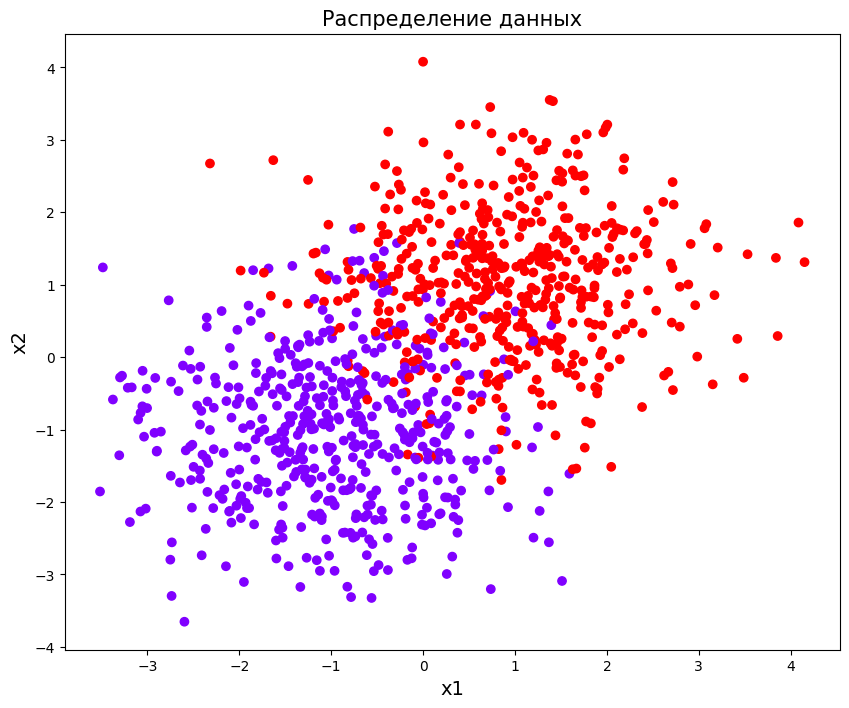

In [92]:
plt.figure(figsize=(10, 8)) # отрисуем его
plt.scatter(data[:, 0], data[:, 1], c=data[:, [2]], cmap='rainbow')
plt.title('Распределение данных', fontsize=15)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.show()

In [93]:
X = data[:, [0, 1]] # обучающая выборка
y = data[:, [2]] # целевая переменная

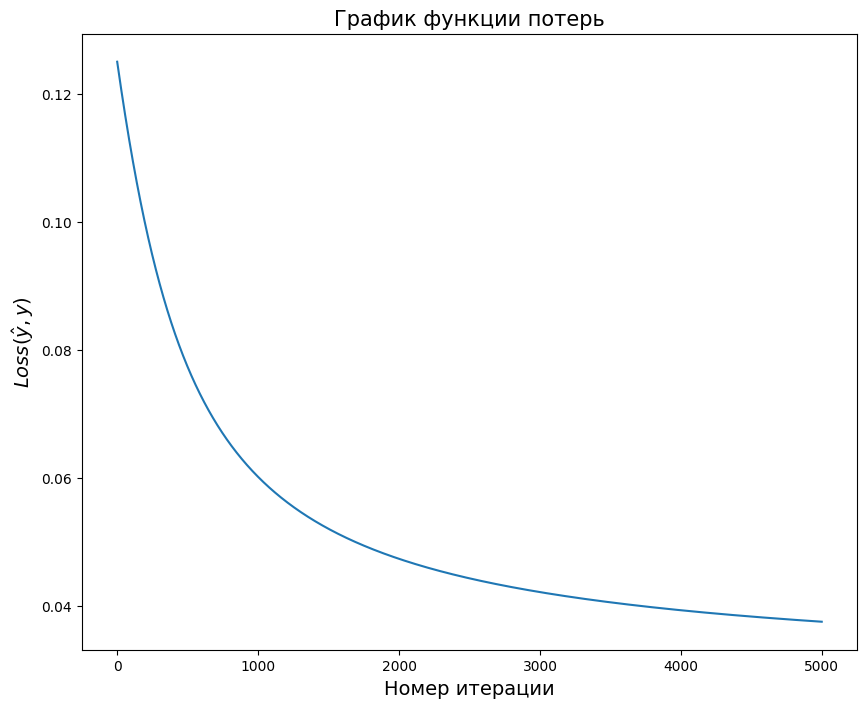

In [94]:
perceptron = Perceptron_Sigmoid()
losses = perceptron.fit(X,y)

plt.figure(figsize=(10, 8))
plt.plot(losses)
plt.title('График функции потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Вуаля! Наконец, мы видим, что наш перцептрон обучается.

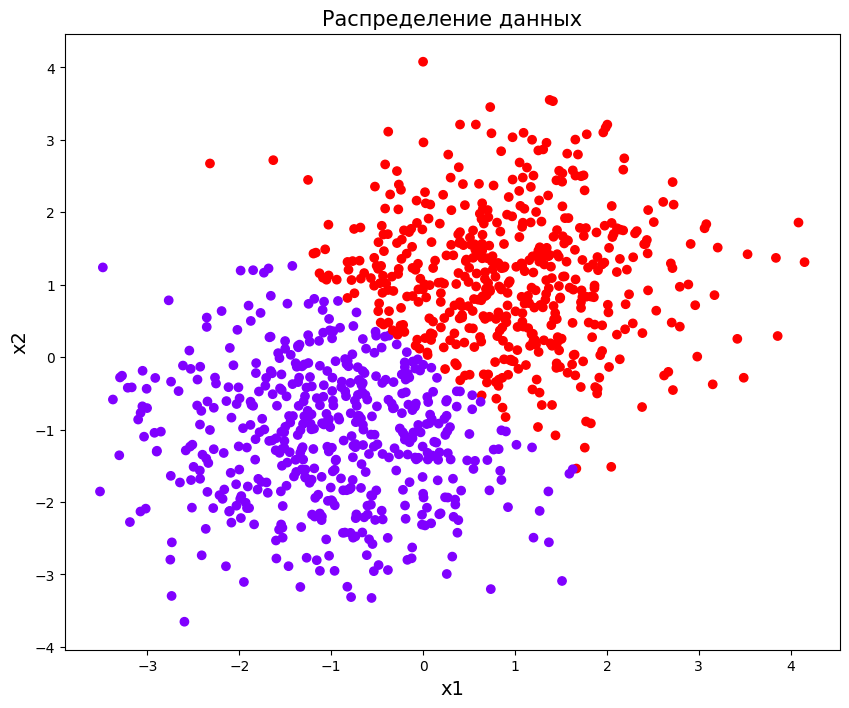

In [95]:
plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1], c=perceptron.forward(X).ravel()>0.5, cmap='rainbow')
plt.title('Распределение данных', fontsize=15)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.show()

Однако данные все равно разделяет линейно. 

In [96]:
print(accuracy_score(perceptron.forward(X).ravel()>0.5, y)) # рассчитаем значение accuracy

0.913


Может быть нам поможет ReLU()? Ведь про сигмоиду мы знаем, что у нее затухают градиенты. 

ReLU выглядит очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В переводе Rectified Linear Unit = "Усечённая линейная функция". Мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Тогда формула для обновления весов при градиентном спуске будет такая:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

Почему в первом случае будет 0? Потому что в $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [97]:
def relu(x):
    return np.maximum(x, 0)

In [98]:
def relu_derivative(x):
    return (x > 0).astype(np.float32)

In [99]:
class Perceptron_ReLU:
    def __init__(self, w, b=0):

        self.w = w
        self.b = b
        
    def activate(self, x):
        return relu(x)
        
    def forward(self, X):

        n = X.shape[0]
        y_pred = np.zeros((X.shape[0],1))
        y_pred = self.activate(X @ self.w.reshape(X.shape[1],1)+self.b)
        return y_pred.reshape(-1,1)
    
    def backward(self, X, y, y_pred, learning_rate=0.005):

        n = len(y)
        y = np.array(y).reshape(-1, 1)
        mask = relu_derivative(y_pred)
        dw = (X.T @ (mask * (y_pred - y)))/n
        db = mask * (y_pred - y)/n

        self.w -= learning_rate*dw
        self.b -= learning_rate*db
    
    def fit(self, X, y, num_epochs=5000):
        loss_values = []  # значения функции потерь на различных итерациях обновления весов

        for i in range(num_epochs):
            y_pred = self.forward(X)
            loss_values.append(mse_loss(y_pred,y))
            self.backward(X,y,y_pred)
        
        return np.array(loss_values)

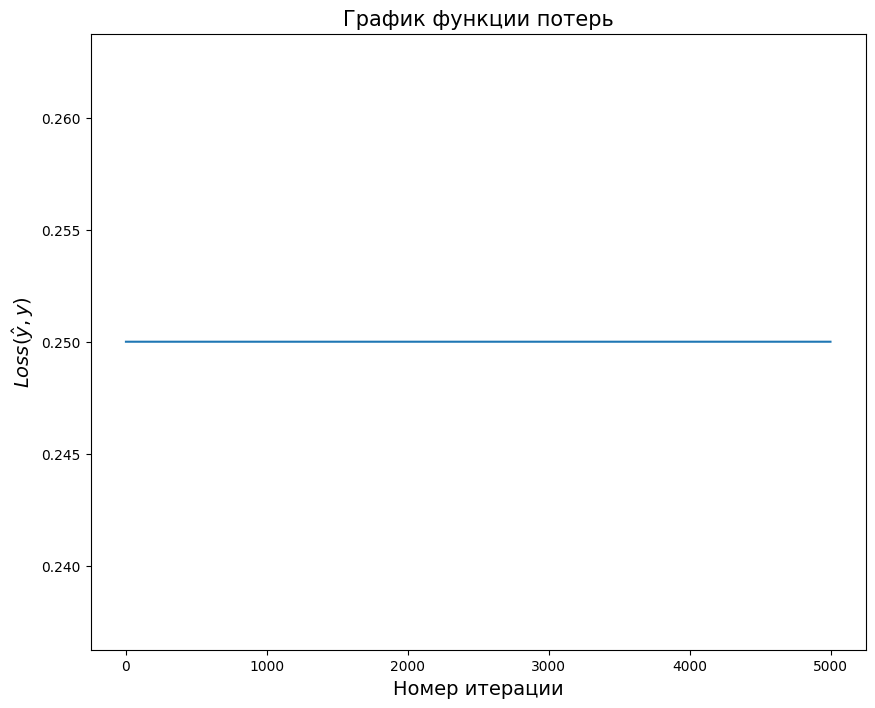

In [100]:
perceptron = Perceptron_ReLU(np.zeros((X.shape[1], 1)))
losses = perceptron.fit(X,y)

plt.figure(figsize=(10, 8))
plt.plot(losses)
plt.title('График функции потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Что мы видим? Что произошло с функцией потерь? 

Ничего удивительного, поскольку одна из проблем ReLU() это так называемые "мертвые" нейроны. А наши веса ведь изначально инициализированы нулями! Поэтому обучение и не происходит.

Заинициализируем их случайными числами (не забудьте закомментировать в классе инициализацию нулями):

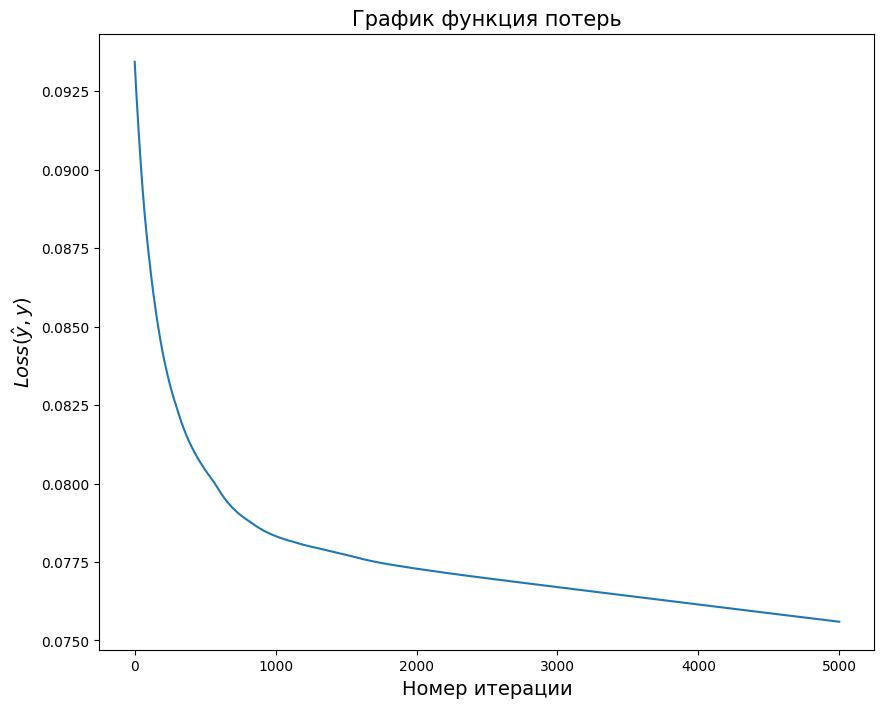

In [101]:
perceptron = Perceptron_ReLU(np.random.rand(*(X.shape[1], 1)))
losses = perceptron.fit(X, y, num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(losses.reshape(-1,))
plt.title('График функция потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

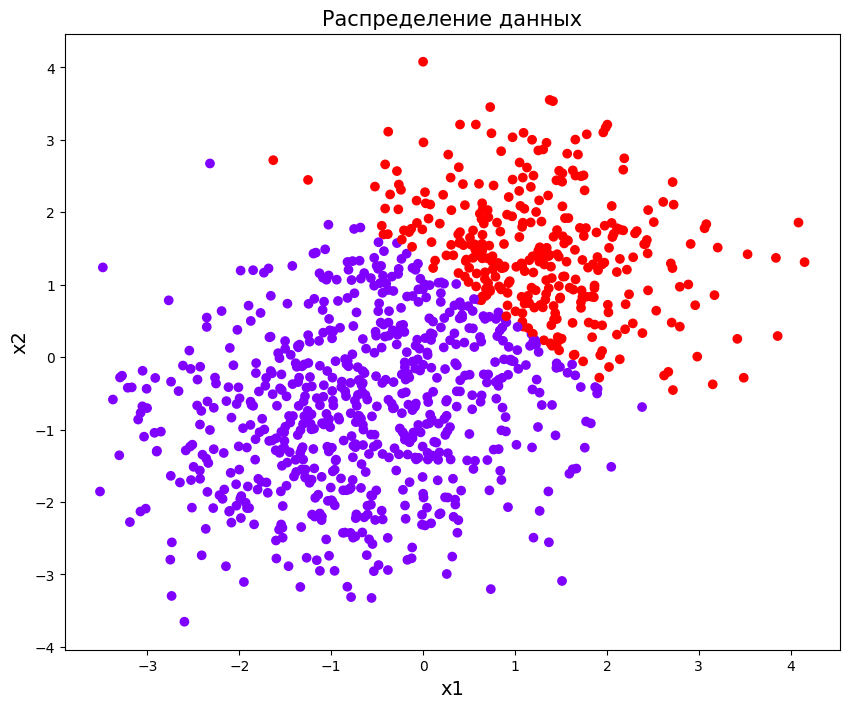

In [102]:
plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1], c=perceptron.forward(X).ravel()>0.5, cmap='rainbow')
plt.title('Распределение данных', fontsize=15)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.show()

Ну вот, другое дело. Однако все равно мы видим линейный решатель. 

In [103]:
print(accuracy_score(np.array(perceptron.forward(X) > 0.5).ravel(), y)) # рассчитаем значение accuracy

0.816


Что ж, можно сделать однозначный вывод: все свои возможности перцептрон исчерпал. Пора переходить к полносвязанным нейронным сетям. 